In [2]:
import numpy as np # linear algebra
from matplotlib import pyplot as plt
#We need these in this file:
import sys
sys.path.append('cropping')
import load_read_name_extractor as lrne
import SVM_classifier_general as svm_general

c:\Users\marti\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
img_list, names = lrne.load_name_and_img("cropped_mean/*jpeg")

In [4]:
print(len(img_list))
print(len(names))

4915
4915


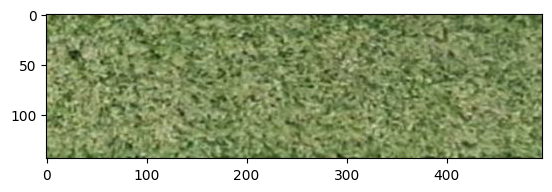

cropped_mean\127_190604_Bj.jpeg


In [5]:
import random

# pick a random index
random_index = random.randint(0, len(img_list)-1)

# get the corresponding image and name
random_img = img_list[random_index]
random_name = names[random_index]

# show the image and print the name
plt.imshow(random_img)
plt.show()
print(random_name)


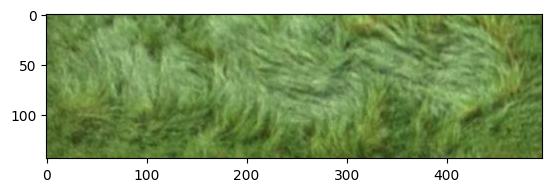

cropped_mean\100_160607_Min.jpeg


In [6]:
# show the first image and print the name
plt.imshow(img_list[0])
plt.show()
print(names[0])


In [7]:
date_ = False
bin_size = 10
n_bins = int(np.floor(100/bin_size))
labels = svm_general.load_labels(bin_size, date_)
print(labels[0])
print(len(labels))

#convert names into [flight_folder, ROI]
names_labels = lrne.it_name_extract_labels_from_img_jpeg(names)
print(names_labels[0])
lodging_score = [[] for _ in range(4915)]

['241' '0' '180529_Bj' '0']
4936
['100', '160607_Min']


In [8]:
#match labels with feature names
lodging_score = svm_general.match_pic_label_to_names_new(lodging_score, labels, names_labels, date_)

In [9]:
import itertools
#print(lodging_score)

lodging_score_int = [[int(char) for char in sublist] for sublist in lodging_score]

flattened_list = list(itertools.chain.from_iterable(lodging_score_int))
#print(flattened_list)
lodging_score = flattened_list
#print(max(lodging_score_int))

In [10]:
count_9 = lodging_score.count(9)
print(count_9)


1


In [11]:
print(np.shape(img_list))
print(np.shape(flattened_list))

(4915, 144, 496, 3)
(4915,)


In [12]:
import torch

def list_gpu_names():
    if torch.cuda.is_available():
        num_gpus = torch.cuda.device_count()
        print(f"Number of available GPUs: {num_gpus}")

        for i in range(num_gpus):
            gpu_name = torch.cuda.get_device_name(i)
            print(f"GPU {i}: {gpu_name}")
    else:
        print("No GPUs available on this machine.")

# Call the function to list GPU names
list_gpu_names()

from torch.utils.data import Dataset, DataLoader, random_split
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Number of available GPUs: 2
GPU 0: NVIDIA GeForce RTX 2070 SUPER
GPU 1: NVIDIA GeForce GTX 1050 Ti
cuda:0


In [21]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from torchvision import transforms

class ImageDataset(Dataset):
    def __init__(self, img_list, lodging_score, transform=None):
        self.img_list = img_list
        self.lodging_score = lodging_score
        self.transform = transform
        self.mean = 0
        
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        img = self.img_list[idx]
        score = self.lodging_score[idx]

        # Convert image to tensor and apply transformations
        if self.transform:
            img = self.transform(img)

        return img, score
    def get_labels(self):
        return self.lodging_score

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((144, 496)),
    #transforms.Grayscale(),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5], std=[0.5])
])
#print(dataSet[0][0].mean(dim=-1))

3


In [25]:
from random import shuffle
# Combine img_list and lodging_score
combined_data = list(zip(img_list, lodging_score))

# Shuffle the combined data
shuffle(combined_data)

# Unzip the shuffled data
img_list, lodging_score = zip(*combined_data)
dataSet = ImageDataset(img_list, lodging_score, transform=transform)
print(dataSet[0][1])

0


In [26]:
#Keep only 500 zeros in the dataset. In attempt to balance the dataset where the zeors are the majority by far.
def filter_data(dataSet):
    filtered_data = []
    count = 0
    for data in dataSet:
        if data[1] == 0 and count < 500:
            filtered_data.append(data)
            count += 1
        elif data[1] != 0:
            filtered_data.append(data)
    return filtered_data
dataSet = filter_data(dataSet)

In [27]:
print(len(dataSet[0]))
print(len(dataSet))
print(dataSet[0][0].shape)

2
3101
torch.Size([3, 144, 496])


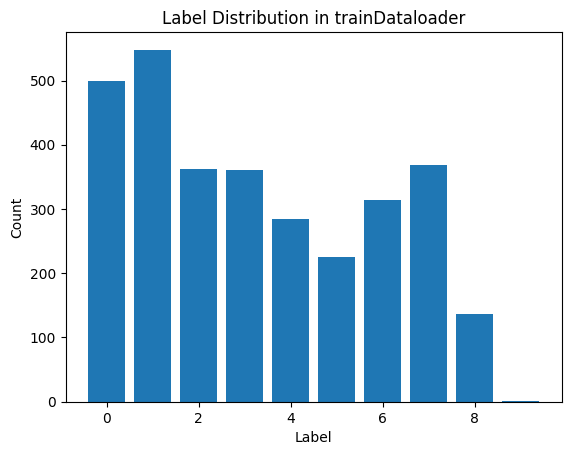

In [24]:
import matplotlib.pyplot as plt

# Extract the labels from the trainDataloader
labels = [data[1] for data in dataSet]

# Count the occurrences of each label
label_counts = {}
for label in labels:
    if label in label_counts:
        label_counts[label] += 1
    else:
        label_counts[label] = 1

# Create a bar plot
plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution in trainDataloader')
plt.show()

In [17]:
print(label_counts)

{3: 360, 0: 2314, 2: 362, 5: 226, 6: 314, 1: 548, 4: 285, 7: 369, 8: 136, 9: 1}
